In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
zip_path = '/content/drive/MyDrive/data.zip'
!cp "{zip_path}" .
!unzip -q data.zip
!rm data.zip

In [5]:
from __future__ import print_function, division

%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os, sys
import math

In [6]:
import keras
import tensorflow as tf
from keras.layers import Input, Lambda, Concatenate
from keras import Model
import keras.backend as K
from keras.applications.vgg16 import preprocess_input
import progressbar
from scipy.ndimage.filters import convolve

In [7]:
class QATM( keras.layers.Layer ):
    def __init__( self, alpha=10, **kwargs ):
        self.alpha = alpha
        super( QATM, self ).__init__( **kwargs )
  
    def build( self, input_shape ):
        self.coef_ref = self.add_weight(shape=(1,),
                                    initializer=keras.initializers.Constant(self.alpha),
                                    name='softmax_coef_ref',)
        self.coef_qry = self.add_weight(shape=(1,),
                                    initializer=keras.initializers.Constant(self.alpha),
                                    name='softmax_coef_qry',)
        
        super( QATM, self ).build( input_shape )
        
    def call( self, x ):
        batch_size, ref_row, ref_col, qry_row, qry_col = [ tf.shape(x)[k] for k in range(5) ]
        x = tf.reshape( x, [batch_size, ref_row * ref_col, qry_row * qry_col ] )
        xm_ref = x - K.max(x,axis=1,keepdims=True)
        conf_ref = tf.nn.softmax( self.coef_ref*xm_ref, axis=1 )
        xm_qry = x - K.max(x,axis=2,keepdims=True)
        conf_qry = tf.nn.softmax( self.coef_qry*xm_qry, axis=2 )
        confidence = K.sqrt(conf_ref * conf_qry )
        conf_values, ind3 = tf.nn.top_k( confidence, k=1 ) # batch_size, ref_size, 1
        ind1, ind2 = tf.meshgrid( tf.range( batch_size ), 
                                  tf.range( ref_row * ref_col ), indexing='ij' )
        ind1 = K.flatten( ind1 )
        ind2 = K.flatten( ind2 )
        ind3 = K.flatten( ind3 )
        indices = K.stack([ind1,ind2,ind3],axis=1)
        values = tf.gather_nd( confidence, indices )
        values = tf.reshape( values, [batch_size, ref_row, ref_col, 1])
        return values
    
    def compute_output_shape( self, input_shape ):
        bs, H, W, _, _ = input_shape
        return (bs, H, W, 1)
class MyNormLayer( keras.layers.Layer ):
    def __init__( self, **kwargs ):
        super( MyNormLayer, self ).__init__( **kwargs )
    
    def build( self, x ):
        super( MyNormLayer, self ).build(x)
        
    def call( self, x ):
        x1, x2 = x
        bs, H, W, _ = [tf.shape(x1)[i] for i in range(4)]
        _, h, w, _ = [tf.shape(x2)[i] for i in range(4)]
        x1 = tf.reshape(x1, ( bs, H*W, -1 ) )
        x2 = tf.reshape(x2, ( bs, h*w, -1 ) )
        concat = tf.concat([x1, x2], axis=1)
        x_mean = K.mean( concat, axis=1, keepdims=True )
        x_std = K.std( concat, axis=1, keepdims = True )
        x1 = (x1 - x_mean) / x_std
        x2 = (x2 - x_mean) / x_std
        x1 = tf.reshape(x1, ( bs, H, W, -1 ) )
        x2 = tf.reshape(x2, ( bs, h, w, -1 ) )
        return [x1, x2]
def compute_score( x, w, h ):
    # score of response strength
    k = np.ones( (h, w) )
    score = convolve( x, k, mode='wrap' )
    score[:, :w//2] = 0
    score[:, math.ceil(-w/2):] = 0
    score[:h//2, :] = 0
    score[math.ceil(-h/2):, :] = 0
    return score
def locate_bbox( a, w, h ):
    row = np.argmax( np.max(a, axis=1) )
    col = np.argmax( np.max(a, axis=0) )
    #print(np.max(np.max(a, axis=1)))
    #print(np.max(np.max(a, axis=0)))
    #print()
    x = col - 1. * w / 2
    y = row - 1. * h / 2
    return x, y, w, h

In [8]:
def create_model( featex, alpha = 1. ):
    T = Input( (None, None, 3), name='template_input' )
    I = Input( (None, None, 3), name='image_input' )
    T_feat = featex(T)
    I_feat = featex(I)
    I_feat, T_feat = MyNormLayer( name='norm_layer' )( [I_feat, T_feat] )
    dist = Lambda( lambda x: tf.einsum( "xabc,xdec->xabde", K.l2_normalize(x[0], axis=-1), K.l2_normalize(x[1], axis=-1) ) , name="cosine_dist")([ I_feat, T_feat ])
    conf_map = QATM(alpha, name='qatm')( dist )
    return Model( [T, I], [conf_map], name='QATM_model' )

In [9]:
vgg19 = keras.applications.vgg19.VGG19( include_top = False, weights = 'imagenet' )

80142336/80134624 [==============================] - 0s 0us/step


In [10]:
# resize conv3_4 to conv1_2
input_ = vgg19.input
conv1_2 = vgg19.get_layer('block1_conv2').output
conv3_4 = vgg19.get_layer('block3_conv4').output
conv3_4 = Lambda( lambda x: tf.image.resize( x[0], size=(tf.shape(x[1])[1], tf.shape(x[1])[2])), name='resized_image' )( [conv3_4, conv1_2] )
concat = Concatenate()( [conv1_2, conv3_4] )
featex = Model( [input_], [concat], name='featex' )
# resize conv1_2 to conv3_4, used when image size is too big
input_ = vgg19.input
conv1_2 = vgg19.get_layer('block1_conv2').output
conv3_4 = vgg19.get_layer('block3_conv4').output
conv1_2 = Lambda( lambda x: tf.image.resize( x[1], size=(tf.shape(x[0])[1], tf.shape(x[0])[2])), name='resized_image' )( [conv3_4, conv1_2] )
concat = Concatenate()( [conv1_2, conv3_4] )
featex2 = Model( [input_], [concat], name='featex2' )

In [11]:
model = create_model( featex , alpha=25)
model_bkup = create_model( featex2 , alpha=25)

In [12]:
def match_pattern(img_path, temp_path, ds_coef, template_coef):
    templates = sorted(os.listdir(temp_path))

    # load image
    image = cv2.imread( img_path )[...,::-1]
    image_plot = image.copy()
    orig_w = image.shape[1]
    orig_h = image.shape[0]
    img_w = round(ds_coef * orig_w)
    img_h = round(ds_coef * orig_h)
    image = cv2.resize(image, (img_w, img_h), interpolation = cv2.INTER_LINEAR) 
    image_ = np.expand_dims(preprocess_input( image ) , axis=0)

    #template_coef = 0.08
    for temp in templates:
      template = cv2.imread( temp_path + temp )[...,::-1]
      width = round(template.shape[1] * ds_coef * template_coef )
      height = round(template.shape[0] * ds_coef * template_coef )
      template = cv2.resize(template, (width, height), interpolation = cv2.INTER_LINEAR) 
      template_ = np.expand_dims(preprocess_input( template ), axis=0)
      if width*height <= 4000:
          val = model.predict( [template_, image_] )
      else:
          # used when image is too big
          val = model_bkup.predict( [template_, image_] )
      # compute geometry average on score map
      val = np.log( val )
      gray = val[0,:,:,0]
      gray = cv2.resize( gray, (image.shape[1], image.shape[0]) )
      score = compute_score( gray, width, height ) 
      score[score>-1e-7] = score.min()
      score = np.exp(score / (height*width)) # reverse number range back after computing geometry average

      #image_plot = cv2.rectangle( image_plot, (int(x), int(y)), (int(x+w), int(y+h)), (255, 0, 0), 2 )
      #image_plot = cv2.putText( image_plot, temp, (int(x), int(y)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (36,255,12), 1 )
      #sc = np.max(np.max(score, axis=1))
      #if sc >= 0.03:
      
      x, y, w, h= locate_bbox( score, width, height )
      image_plot = cv2.rectangle( image_plot, (int(x/ds_coef), int(y/ds_coef)), (int((x+w)/ds_coef), int((y+h)/ds_coef)), (255, 0, 0), 2 )
      image_plot = cv2.putText( image_plot, temp, (int(x/ds_coef), int(y/ds_coef)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (36,255,12), 2 )
    
    plt.figure(figsize=(20,10))
    plt.imshow(image_plot)
    plt.show()
    cv2.imwrite('dum_qatm.png', image_plot[:,:,::-1])
    #print(image.shape)
    #print(template.shape)

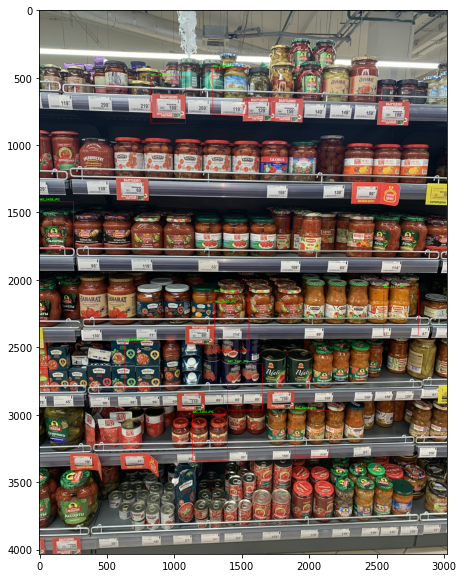

In [17]:
#img_path = '/content/drive/MyDrive/data/test/IMG_3493.JPG' 
#temp_path = '/content/drive/MyDrive/data/train_1/'
#img_path = 'test_1/IMG_3493.JPG' 

img_path = '/content/drive/MyDrive/data/test/IMG_3497.JPG' 
temp_path = 'train_1/'

downscale = 0.3
template_coef = 0.085
match_pattern(img_path, temp_path, downscale, template_coef)